# Bi-LSTM for CoNLL Dataset (with GloVe)

### Author: Omer Waseem
#### Description: This Python notebook trains and evaluates a Bi-LSTM on the CoNLL dataset using GloVe features

In [1]:
from dataprep import conll_words, neel_words
from helper import load_glove_dict, get_glove_vector, accuracy, entity_count, one_hot_encode, one_hot_decode
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, CuDNNLSTM, Bidirectional
from keras.callbacks import TensorBoard

/home/ow/miniconda3/envs/datamgt/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load GloVe features

In [2]:
g_file = '../glove/glove.twitter.27B.50d.txt'
g_dict = load_glove_dict(g_file)

### Load all data (training and test) to create a vocabulary dictionary

In [3]:
c_train_file = './datasets/CoNLL2003/eng.train'
c_testa_file = './datasets/CoNLL2003/eng.testa'
c_testb_file = './datasets/CoNLL2003/eng.testb'
c_testc_file = './datasets/CoNLL2003/eng.testc'

c_train_words, c_train_pos, c_train_chunk, c_train_entity = conll_words(c_train_file)
c_testa_words, c_testa_pos, c_testa_chunk, c_testa_entity = conll_words(c_testa_file)
c_testb_words, c_testb_pos, c_testb_chunk, c_testb_entity = conll_words(c_testb_file)
c_testc_words, c_testc_pos, c_testc_chunk, c_testc_entity = conll_words(c_testc_file)

In [4]:
combined_words = c_train_words + c_testa_words + c_testb_words + c_testc_words

In [5]:
print(len(c_train_words))
print(len(c_testa_words))
print(len(c_testb_words))
print(len(c_testc_words))
print(len(combined_words))

203621
51362
46435
35
301453


### Create char set, char dictionary and find length of maximum word for padding

In [6]:
char_set = set()
char_dict = {}
max_word_len = 0
for word in combined_words:
    if len(word) > max_word_len:
        max_word_len = len(word)
    for char in word:
        char_set.add(char)

for i, char in enumerate(char_set):
    char_dict[char] = int(i) + 1 # index 0 should not be used in vocab, since its used for masking

# ensure index 0 is not used
for key in char_dict.keys():
    if char_dict[key] == 0:
        raise KeyError('Error: index 0 is used with key: ', key)

print('Maximum word length:', max_word_len)

Maximum word length: 61


### Define hyperparameters

#### val_acc: 0.9566 on testa
max_features = len(char_set) + 1  
maxlen = 70  
batch_size = 32  
epochs = 20  
drop_out = 0.5  

In [7]:
max_features = len(char_set) + 1
maxlen = 70
glove_len = 50
batch_size = 256
epochs = 60
drop_out = 0.5

### Convert training and test words into padded int vectors using char dictionary

In [8]:
def word2vec(words):
    out = []
    for word in words:
        temp = []
        for char in word:
            temp.append(char_dict[char])
        out.append(temp)
    return np.array(out)

In [9]:
train_words = sequence.pad_sequences(word2vec(c_train_words), maxlen=maxlen)
testa_words = sequence.pad_sequences(word2vec(c_testa_words), maxlen=maxlen)
testb_words = sequence.pad_sequences(word2vec(c_testb_words), maxlen=maxlen)
testc_words = sequence.pad_sequences(word2vec(c_testc_words), maxlen=maxlen)

### Append GolVe features

In [10]:
train_glove = []
for i in range(len(train_words)):
    train_glove.append(np.concatenate((train_words[i], get_glove_vector(g_dict, c_train_words[i]))))
train_glove = np.array(train_glove, dtype=np.float32)

testa_glove = []
for i in range(len(testa_words)):
    testa_glove.append(np.concatenate((testa_words[i], get_glove_vector(g_dict, c_testa_words[i]))))
testa_glove = np.array(testa_glove, dtype=np.float32)

testb_glove = []
for i in range(len(testb_words)):
    testb_glove.append(np.concatenate((testb_words[i], get_glove_vector(g_dict, c_testb_words[i]))))
testb_glove = np.array(testb_glove, dtype=np.float32)

testc_glove = []
for i in range(len(testc_words)):
    testc_glove.append(np.concatenate((testc_words[i], get_glove_vector(g_dict, c_testc_words[i]))))
testc_glove = np.array(testc_glove, dtype=np.float32)

### One-Hot encode entities for training and test data

In [11]:
# one-hot formatting: [PER LOC ORG MISC O]
train_entities = one_hot_encode(c_train_entity)
testa_entities = one_hot_encode(c_testa_entity)
testb_entities = one_hot_encode(c_testb_entity)
testc_entities = one_hot_encode(c_testc_entity)

### Train Bi-LSTM model using Keras

In [12]:
model = Sequential()
model.add(Embedding(max_features, 480, input_length=maxlen + glove_len))
model.add(Bidirectional(CuDNNLSTM(240, return_sequences = True)))
model.add(Bidirectional(CuDNNLSTM(160, return_sequences = True)))
model.add(Bidirectional(CuDNNLSTM(80)))
model.add(Dropout(drop_out))
model.add(Dense(5, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_glove, train_entities,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=[testa_glove, testa_entities],
          verbose=1)

Train on 203621 samples, validate on 51362 samples
Epoch 1/60
203621/203621 [==============================] - 134s 660us/step - loss: 0.5314 - acc: 0.8360 - val_loss: 0.3434 - val_acc: 0.8648
Epoch 2/60
203621/203621 [==============================] - 131s 645us/step - loss: 0.3289 - acc: 0.8660 - val_loss: 0.3027 - val_acc: 0.8797
Epoch 3/60
203621/203621 [==============================] - 131s 643us/step - loss: 0.2902 - acc: 0.8873 - val_loss: 0.2562 - val_acc: 0.9132
Epoch 4/60
203621/203621 [==============================] - 131s 645us/step - loss: 0.2620 - acc: 0.9048 - val_loss: 0.2345 - val_acc: 0.9202
Epoch 5/60
203621/203621 [==============================] - 131s 646us/step - loss: 0.2218 - acc: 0.9250 - val_loss: 0.1935 - val_acc: 0.9406
Epoch 6/60
203621/203621 [==============================] - 132s 646us/step - loss: 0.1870 - acc: 0.9398 - val_loss: 0.1802 - val_acc: 0.9430
Epoch 7/60
203621/203621 [==============================] - 132s 647us/step - loss: 0.1637 - acc:

Epoch 58/60
203621/203621 [==============================] - 132s 647us/step - loss: 0.0576 - acc: 0.9803 - val_loss: 0.1830 - val_acc: 0.9620
Epoch 59/60
203621/203621 [==============================] - 131s 645us/step - loss: 0.0578 - acc: 0.9801 - val_loss: 0.1776 - val_acc: 0.9613
Epoch 60/60
203621/203621 [==============================] - 131s 645us/step - loss: 0.0561 - acc: 0.9807 - val_loss: 0.1858 - val_acc: 0.9600


### Plot accuracy and loss

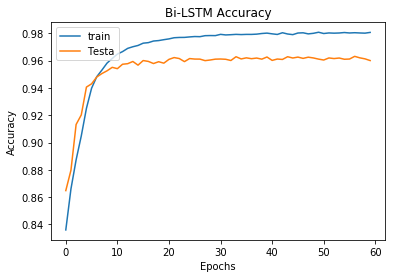

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Bi-LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
#plt.xticks(range(epochs))
plt.legend(['train', 'Testa'], loc='upper left')
plt.show()

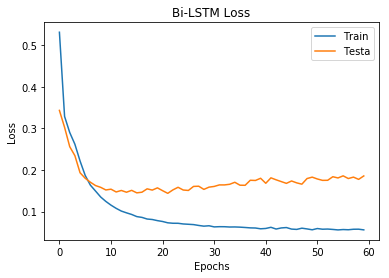

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Bi-LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
#plt.xticks(range(epochs))
plt.legend(['Train', 'Testa'], loc='upper right')
plt.show()

### Predict test entities using trained model

#### Evaluation for testa

In [15]:
testa_pred = one_hot_decode(model.predict(testa_glove))
accuracy(c_testa_entity, testa_pred)

accuracy = 49310 / 51362 = 0.960048


In [16]:
precision_recall_fscore_support(c_testa_entity, testa_pred)

(array([0.81217309, 0.84267631, 0.99122234, 0.65916955, 0.89384359]),
 array([0.8156638 , 0.73501577, 0.99300732, 0.72848948, 0.8529692 ]),
 array([0.8139147 , 0.7851727 , 0.99211403, 0.69209809, 0.87292818]),
 array([ 2094,  1268, 42759,  2092,  3149]))

In [17]:
entity_count(c_testa_entity)

ORG: 2092
PER: 3149
LOC: 2094
MISC: 1268
O: 42759


#### Evaluation for testb

In [18]:
testb_pred = one_hot_decode(model.predict(testb_glove))
accuracy(c_testb_entity, testb_pred)

accuracy = 43806 / 46435 = 0.943383


In [19]:
precision_recall_fscore_support(c_testb_entity, testb_pred)

(array([0.74375306, 0.71047009, 0.98955737, 0.63579103, 0.82842026]),
 array([0.78857143, 0.72440087, 0.98413485, 0.6875    , 0.79047962]),
 array([0.76550681, 0.71736785, 0.98683866, 0.66063523, 0.80900535]),
 array([ 1925,   918, 38323,  2496,  2773]))

In [20]:
entity_count(c_testb_entity)

ORG: 2496
PER: 2773
LOC: 1925
MISC: 918
O: 38323


#### Evaluation for testc

In [21]:
testc_pred = one_hot_decode(model.predict(testc_glove))
accuracy(c_testc_entity, testc_pred)

accuracy = 34 / 35 = 0.971429


In [22]:
precision_recall_fscore_support(c_testc_entity, testc_pred)

/home/ow/miniconda3/envs/datamgt/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(array([0., 1., 1., 1., 1.]),
 array([0. , 0.5, 1. , 1. , 1. ]),
 array([0.        , 0.66666667, 1.        , 1.        , 1.        ]),
 array([ 0,  2, 29,  2,  2]))

In [23]:
entity_count(c_testc_entity)

ORG: 2
PER: 2
LOC: 0
MISC: 2
O: 29
